In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import lightgbm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

import shap
# load JS visualization code to notebook
shap.initjs()

import itertools
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def evaluate_results(y_test_val, y_predict_val, print_status = False):
    f1 = f1_score(y_test_val, y_predict_val)
    roc = roc_auc_score(y_test_val, y_predict_val)
    rec = recall_score(y_test_val, y_predict_val, average='binary') 
    prc = precision_score(y_test_val, y_predict_val, average='binary')
    if print_status:
        print('Classification results:')
        print("f1: %.2f%%" % (f1 * 100.0)) 
        print("roc: %.2f%%" % (roc * 100.0))
        print("recall: %.2f%%" % (rec * 100.0))
        print("precision: %.2f%%" % (prc * 100.0))
    else:
        return f1, roc, rec, prc

https://archive.ics.uci.edu/ml/datasets/Apartment+for+rent+classified

## Урок 7. Интерпретация прогнозов модели (SHAP): объясняем поведение модели на отдельных наблюдениях
### Домашнее задание
Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

Feature selection:

RFE - recursive feature elimination (есть в sklearn)
Boruta - shadow features
Target permutation

Набор данных взят отсюда - https://www.kaggle.com/harlfoxem/housesalesprediction

In [3]:
df = pd.read_csv("kc_house_data.csv")
# https://archive-beta.ics.uci.edu/ml/datasets/online+shoppers+purchasing+intention+dataset
# https://archive.ics.uci.edu/ml/machine-learning-databases/00468/
"""Of the 12,330 sessions in the dataset, 84.5% (10,422) were negative class samples that did not end 
with shopping, and the rest (1908) were positive class samples ending with shopping."""
df = pd.read_csv('online_shoppers_intention.csv')
print(df.shape)
df.head(3)

(12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False


In [4]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [5]:
for col in df.columns:
    print(col, '\n', df[col].unique(), '\n')

Administrative 
 [ 0  1  2  4 12  3 10  6  5  9  8 16 13 11  7 18 14 17 19 15 24 22 21 20
 23 27 26] 

Administrative_Duration 
 [  0.         53.         64.6       ... 167.9107143 305.125
 150.3571429] 

Informational 
 [ 0  1  2  4 16  5  3 14  6 12  7  9 10  8 11 24 13] 

Informational_Duration 
 [  0.   120.    16.   ... 547.75 368.25 211.25] 

ProductRelated 
 [  1   2  10  19   0   3  16   7   6  23  13  20   8   5  32   4  45  14
  52   9  46  15  22  11  12  36  42  27  90  18  38  17 128  25  30  21
  51  26  28  31  24  50  96  49  68  98  67  55  35  37  29  34  71  63
  87  40  33  54  64  75  39 111  81  61  47  44  88 149  41  79  66  43
 258  80  62  83 173  48  58  57  56  69  82  59 109 287  53  84  78 137
 113  89  65  60 104 129  77  74  93  76  72 194 140 110 132 115  73 328
 160  86 150  95 130 151 117 124 127 125 116 105  92 157 154 220 187 112
 131 159  94 204 142 206 102 313 145  85  97 198 181 126 106 101 108 119
  70 122  91 276 100 291 114 172 217 141 133 15

In [6]:
df.loc[df['Revenue']==True, 'Revenue'].count()

1908

In [7]:
initial_features = df.columns
target = initial_features[-1:]
initial_features = initial_features[:-1]
print(initial_features, target)

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend'],
      dtype='object') Index(['Revenue'], dtype='object')


In [8]:
numerical_features = df.select_dtypes(include=np.number).columns
cat_features = pd.DataFrame(columns = set(initial_features) - set(numerical_features)).columns
print(numerical_features) # pd.DataFrame()
print(cat_features)

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType'],
      dtype='object')
Index(['Month', 'Weekend', 'VisitorType'], dtype='object')


In [9]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[initial_features], df[target], random_state=0)

Соберем пайплайн

In [10]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

    

    
#continuous_columns = ["bedrooms", "yr_built", 'sqft_living', 'sqft_lot']

final_transformers = list()

for cat_col in cat_features:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))


for numerical_col in numerical_features:
    numerical_features_transformer = Pipeline([('selector', NumberSelector(key=numerical_col)),
                                               ('scaler', StandardScaler())
                                              ])
    final_transformers.append((numerical_col, numerical_features_transformer))
    
    
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

### Модель - LGBMClassifier

In [11]:
LGBMClassifier_pipline = Pipeline([
    ('features',feats),
    ('classifier', lightgbm.LGBMClassifier(learning_rate=0.09, max_depth=5, random_state=12, 
                                  category_features = list(cat_features))) # max_depth<=0 means no limit
])


In [12]:
#обучим наш пайплайн
LGBMClassifier_pipline.fit(X_train, np.ravel(y_train))

[LightGBM] [Warning] Unknown parameter: category_features


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Month',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Month')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Month'))])),
                                                ('Weekend',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Weekend')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Weekend'))])),
                                                ('VisitorType',
                                                 Pipeline(steps=[('selector',
               

In [13]:
LGBMClassifier_pipline.score(X_train, y_train), LGBMClassifier_pipline.score(X_test, y_test)

(0.9369525251432897, 0.8952319169639961)

In [14]:
LGBM_features = pd.DataFrame(LGBMClassifier_pipline[1].feature_importances_,
                             LGBMClassifier_pipline[1].feature_name_,
                             columns=['coefficient'])
LGBM_features.sort_values(by=['coefficient'], ascending=False)
# with categorical features namber of columns more then initial!

,coefficient
Column_20,269
Column_22,246
Column_16,239
Column_23,224
Column_19,195
Column_15,139
Column_18,111
Column_21,109
Column_28,106
Column_12,90


## Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

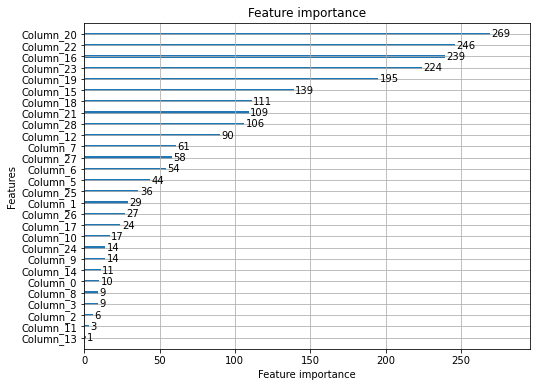

In [15]:
lightgbm.plot_importance(LGBMClassifier_pipline[1], figsize=(8,6))

Посчитаем MAE и коэффициент детерминации (R2)

In [16]:
predictions =  LGBMClassifier_pipline.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(0.10476808303600389, 0.25736660611104656)

In [17]:
evaluate_results(y_test, predictions, print_status = True)

Classification results:
f1: 65.96%
roc: 77.68%
recall: 59.73%
precision: 73.65%


In [18]:
from sklearn.inspection import permutation_importance
r = permutation_importance(LGBMClassifier_pipline, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

In [19]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{LGBMClassifier_pipline[1].feature_name_[i]:<8} "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

Column_8 0.149 +/- 0.005
Column_10 0.014 +/- 0.002
Column_7 0.010 +/- 0.003
Column_0 0.004 +/- 0.001
Column_5 0.003 +/- 0.002
Column_6 0.003 +/- 0.002
Column_4 0.003 +/- 0.002
Column_12 0.002 +/- 0.001
Column_14 0.001 +/- 0.001
Column_3 0.001 +/- 0.001
Column_11 0.001 +/- 0.000
Column_9 0.000 +/- 0.001
Column_1 0.000 +/- 0.001
Column_2 0.000 +/- 0.000
Column_15 -0.000 +/- 0.001
Column_16 -0.000 +/- 0.000
Column_13 -0.000 +/- 0.001


# SHAP

ссылка на проект - https://github.com/slundberg/shap

Wiki - https://en.wikipedia.org/wiki/Shapley_value

In [20]:
"""model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])"""

'model = xgboost.train({"learning_rate": 0.01}, \n                      xgboost.DMatrix(X_train, label=y_train), 100)\n\n# explain the model\'s predictions using SHAP\n# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)\nexplainer = shap.TreeExplainer(model)\nshap_values = explainer.shap_values(X_train)\n\n# visualize the first prediction\'s explanation (use matplotlib=True to avoid Javascript)\nshap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])'

In [23]:
X_train = X_train.drop(columns=cat_features)
X_test = X_test.drop(columns=cat_features)

In [30]:
y_train = y_train.astype(int)

In [39]:
import xgboost

In [40]:
# не получилось - KeyError: 'objective'
"""model = lightgbm.train({"learning_rate":0.09, "max_depth":5, "random_state":12,
                       "num_leaves": 10},
                       lightgbm.Dataset(X_train, label=y_train), 40)"""
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

График выше показывает вклад каждого признака в предсказание модели относительно базового значения (средний прогноз по всему тренировочному набору данных). 

- Цвет точки - это значение признака
- То, насколько точка далека от вертикальной линии (серой) влево - показывает ее вклад как отрицательный
- То, насколько точка далека от вертикальной линии (серой) вправо - показывает ее положительный вклад

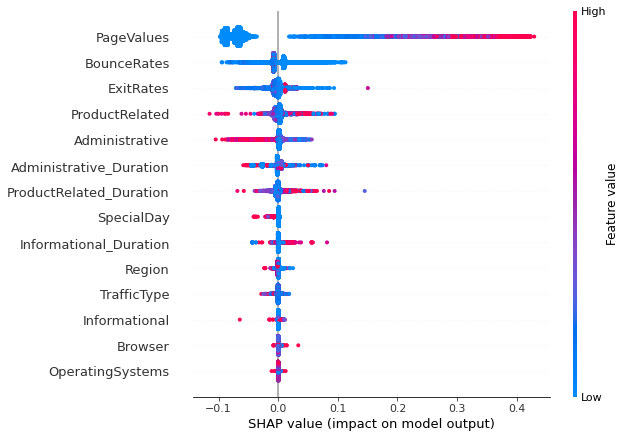

In [41]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Как его читать: 

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точка на графике, тем выше значения признака в ней

Из графика можно сделать интересные выводы и проверить их адекватность:
- чем больше pagevalues и Bounce Rate, тем выше вероятность покупки
- на факт покупки больше всего влияют exit rates, productrelated duration и informational duration
- остальные признаки в основном сосредоточены около 0

Можно даже просто взять средние значения SHAP для каждого признака

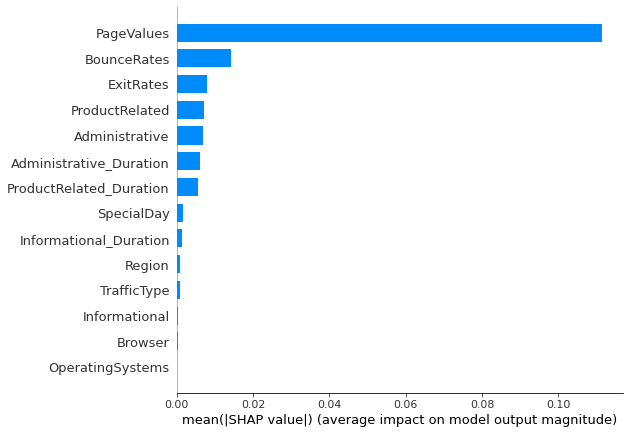

In [42]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

"Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related" and "Product Related Duration" represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. The "Bounce Rate", "Exit Rate" and "Page Value" features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session. The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session. The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction. The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the year.